In [1]:
import sys
sys.path.append('../')

# Datasets

We create a dataset by following the instructions [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets)

In [13]:
from pathlib import Path

DATAROOT = Path('../data/output/denoiser')
FRAGMENTS_DIR = Path('../data/input/train')
REGION_SIZE = 256
SV = '28'

DATAROOT.mkdir(parents=True, exist_ok=True)
print('Dataroot:', DATAROOT)

Dataroot: ../data/output/denoiser


In [14]:
from sp.data.img2label import Img2LabelDataset

Img2LabelDataset.preprocess(
    REGION_SIZE,
    FRAGMENTS_DIR,
    outdir=DATAROOT,
    sample_path=f'surface_volume/{SV}.tif',
    label_path='ir.png',
    mask_samples_only=True,
    splits=[
        ('train', ['1', '2']),
        ('val', ['3']),
        ('test', ['3'])
    ])

Split: train:   0%|          | 0/2 [00:00<?, ?it/s]

Fold: 1:   0%|          | 0/800 [00:00<?, ?it/s]

Fold: 2:   0%|          | 0/2204 [00:00<?, ?it/s]

Split: val:   0%|          | 0/1 [00:00<?, ?it/s]

Fold: 3:   0%|          | 0/630 [00:00<?, ?it/s]

Split: test:   0%|          | 0/1 [00:00<?, ?it/s]

Fold: 3:   0%|          | 0/630 [00:00<?, ?it/s]

Done!


[fold_A] =  ../data/output/denoiser/A
[fold_B] =  ../data/output/denoiser/B
[fold_AB] =  ../data/output/denoiser
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = train, use 1752/1752 images
split = train, number of images = 1752
split = val, use 324/324 images
split = val, number of images = 324
split = test, use 324/324 images
split = test, number of images = 324
A  B  __meta__	meta.json  test  train	val


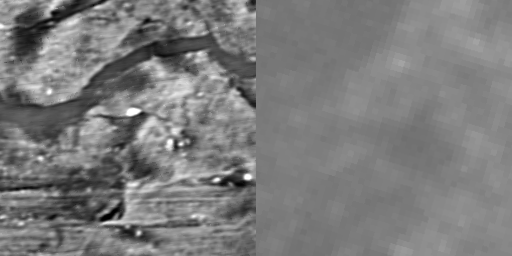

In [15]:
!python datasets/combine_A_and_B.py \
    --fold_A $DATAROOT/A \
    --fold_B $DATAROOT/B \
    --fold_AB $DATAROOT
!ls $DATAROOT

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

Image.open(DATAROOT / 'train/1.png')

# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_pix2pix_model.sh [edges2shoes, sat2map, map2sat, facades_label2photo, and day2night]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [16]:
MODEL_NAME = 'xray2ir'

In [17]:
!mkdir -p ./checkpoints/$MODEL_NAME
!ls ./checkpoints/$MODEL_NAME

10_net_D.pth  20_net_G.pth  35_net_D.pth  5_net_G.pth	    train_opt.txt
10_net_G.pth  25_net_D.pth  35_net_G.pth  latest_net_D.pth  web
15_net_D.pth  25_net_G.pth  40_net_D.pth  latest_net_G.pth
15_net_G.pth  30_net_D.pth  40_net_G.pth  loss_log.txt
20_net_D.pth  30_net_G.pth  5_net_D.pth   test_opt.txt


# Training

-   `python train.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --direction BtoA`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. Add `--direction BtoA` if you want to train a model to transfrom from class B to A.

**NOTE: Attach --continue_train if it gets stuck**

In [32]:
!python train.py --dataroot $DATAROOT --name $MODEL_NAME --model pix2pix --gpu_ids 0 --continue_train

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: True                          	[default: False]
                crop_size: 256                           
                 dataroot: ../data/output/denoiser       	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                      



Could not connect to Visdom server. 
 Trying to start a server....
Command: /home/tony/.cache/pypoetry/virtualenvs/sp-LVeQk688-py3.10/bin/python -m visdom.server -p 8097 &>/dev/null &
create web directory ./checkpoints/xray2ir/web...
/home/tony/.cache/pypoetry/virtualenvs/sp-LVeQk688-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
learning rate 0.0002000 -> 0.0002000
(epoch: 1, iters: 100, time: 0.063, data: 0.067) G_GAN: 4.752 G_L1: 6.737 D_real: 0.000 D_fake: 0.039 
(epoch: 1, iters: 200, time: 

(epoch: 4, iters: 1644, time: 0.065, data: 0.001) G_GAN: 1.809 G_L1: 13.822 D_real: 0.002 D_fake: 0.478 
(epoch: 4, iters: 1744, time: 0.064, data: 0.001) G_GAN: 1.816 G_L1: 8.194 D_real: 0.480 D_fake: 0.300 
End of epoch 4 / 200 	 Time Taken: 65 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 5, iters: 92, time: 0.064, data: 0.001) G_GAN: 4.217 G_L1: 8.336 D_real: 0.001 D_fake: 0.047 
(epoch: 5, iters: 192, time: 0.170, data: 0.001) G_GAN: 2.069 G_L1: 9.778 D_real: 0.407 D_fake: 0.304 
(epoch: 5, iters: 292, time: 0.064, data: 0.001) G_GAN: 1.533 G_L1: 11.149 D_real: 0.990 D_fake: 0.439 
(epoch: 5, iters: 392, time: 0.064, data: 0.001) G_GAN: 1.887 G_L1: 7.839 D_real: 0.099 D_fake: 0.276 
(epoch: 5, iters: 492, time: 0.066, data: 0.001) G_GAN: 4.061 G_L1: 8.925 D_real: 0.000 D_fake: 0.042 
(epoch: 5, iters: 592, time: 0.116, data: 0.001) G_GAN: 2.042 G_L1: 11.321 D_real: 0.276 D_fake: 0.234 
(epoch: 5, iters: 692, time: 0.064, data: 0.001) G_GAN: 4.991 G_L1: 7.370 D_real: 0.000 D_fak

(epoch: 9, iters: 384, time: 0.171, data: 0.001) G_GAN: 2.722 G_L1: 7.848 D_real: 0.019 D_fake: 0.093 
(epoch: 9, iters: 484, time: 0.064, data: 0.001) G_GAN: 1.343 G_L1: 12.723 D_real: 0.009 D_fake: 0.904 
(epoch: 9, iters: 584, time: 0.064, data: 0.001) G_GAN: 1.978 G_L1: 8.912 D_real: 0.001 D_fake: 0.218 
(epoch: 9, iters: 684, time: 0.063, data: 0.001) G_GAN: 1.345 G_L1: 9.755 D_real: 0.000 D_fake: 1.316 
(epoch: 9, iters: 784, time: 0.114, data: 0.001) G_GAN: 4.411 G_L1: 9.823 D_real: 0.000 D_fake: 0.020 
(epoch: 9, iters: 884, time: 0.064, data: 0.001) G_GAN: 2.403 G_L1: 6.975 D_real: 0.000 D_fake: 0.313 
(epoch: 9, iters: 984, time: 0.064, data: 0.001) G_GAN: 1.879 G_L1: 8.791 D_real: 1.160 D_fake: 0.172 
saving the latest model (epoch 9, total_iters 15000)
(epoch: 9, iters: 1084, time: 0.063, data: 0.001) G_GAN: 1.448 G_L1: 11.226 D_real: 0.000 D_fake: 0.787 
(epoch: 9, iters: 1184, time: 0.113, data: 0.001) G_GAN: 2.018 G_L1: 9.236 D_real: 0.268 D_fake: 0.205 
(epoch: 9, iters

(epoch: 13, iters: 776, time: 0.064, data: 0.001) G_GAN: 2.600 G_L1: 13.451 D_real: 0.367 D_fake: 0.082 
(epoch: 13, iters: 876, time: 0.064, data: 0.001) G_GAN: 3.791 G_L1: 7.789 D_real: 0.001 D_fake: 0.039 
(epoch: 13, iters: 976, time: 0.170, data: 0.001) G_GAN: 1.545 G_L1: 9.377 D_real: 0.005 D_fake: 0.605 
(epoch: 13, iters: 1076, time: 0.064, data: 0.001) G_GAN: 1.574 G_L1: 10.706 D_real: 0.000 D_fake: 0.515 
(epoch: 13, iters: 1176, time: 0.064, data: 0.001) G_GAN: 2.097 G_L1: 10.726 D_real: 0.025 D_fake: 0.477 
(epoch: 13, iters: 1276, time: 0.064, data: 0.001) G_GAN: 3.199 G_L1: 7.670 D_real: 0.001 D_fake: 0.081 
(epoch: 13, iters: 1376, time: 0.116, data: 0.001) G_GAN: 2.213 G_L1: 7.633 D_real: 0.015 D_fake: 0.217 
(epoch: 13, iters: 1476, time: 0.064, data: 0.001) G_GAN: 2.296 G_L1: 7.334 D_real: 0.000 D_fake: 0.180 
(epoch: 13, iters: 1576, time: 0.064, data: 0.001) G_GAN: 1.988 G_L1: 12.854 D_real: 0.585 D_fake: 0.187 
(epoch: 13, iters: 1676, time: 0.064, data: 0.001) G_G

(epoch: 17, iters: 1268, time: 0.064, data: 0.001) G_GAN: 2.413 G_L1: 7.559 D_real: 1.437 D_fake: 0.104 
(epoch: 17, iters: 1368, time: 0.066, data: 0.001) G_GAN: 1.580 G_L1: 10.048 D_real: 0.605 D_fake: 0.424 
(epoch: 17, iters: 1468, time: 0.064, data: 0.001) G_GAN: 1.385 G_L1: 6.955 D_real: 0.705 D_fake: 0.299 
(epoch: 17, iters: 1568, time: 0.114, data: 0.001) G_GAN: 0.937 G_L1: 7.137 D_real: 0.681 D_fake: 1.412 
(epoch: 17, iters: 1668, time: 0.066, data: 0.001) G_GAN: 2.363 G_L1: 11.101 D_real: 0.184 D_fake: 0.146 
End of epoch 17 / 200 	 Time Taken: 66 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 18, iters: 16, time: 0.066, data: 0.001) G_GAN: 1.445 G_L1: 7.404 D_real: 0.574 D_fake: 0.180 
(epoch: 18, iters: 116, time: 0.064, data: 0.001) G_GAN: 2.051 G_L1: 7.634 D_real: 0.050 D_fake: 0.340 
(epoch: 18, iters: 216, time: 0.173, data: 0.001) G_GAN: 3.021 G_L1: 6.584 D_real: 0.000 D_fake: 0.077 
saving the latest model (epoch 18, total_iters 30000)
(epoch: 18, iters: 316, time

(epoch: 21, iters: 1660, time: 0.066, data: 0.001) G_GAN: 1.175 G_L1: 8.866 D_real: 1.105 D_fake: 0.477 
End of epoch 21 / 200 	 Time Taken: 66 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 22, iters: 8, time: 0.184, data: 0.001) G_GAN: 2.367 G_L1: 13.689 D_real: 0.377 D_fake: 0.172 
(epoch: 22, iters: 108, time: 0.065, data: 0.000) G_GAN: 2.660 G_L1: 8.212 D_real: 0.004 D_fake: 0.148 
(epoch: 22, iters: 208, time: 0.065, data: 0.001) G_GAN: 2.031 G_L1: 10.495 D_real: 0.456 D_fake: 0.142 
(epoch: 22, iters: 308, time: 0.065, data: 0.001) G_GAN: 1.260 G_L1: 11.283 D_real: 0.000 D_fake: 0.486 
(epoch: 22, iters: 408, time: 0.111, data: 0.001) G_GAN: 1.447 G_L1: 6.135 D_real: 2.228 D_fake: 0.093 
(epoch: 22, iters: 508, time: 0.064, data: 0.001) G_GAN: 4.478 G_L1: 6.648 D_real: 0.000 D_fake: 0.016 
(epoch: 22, iters: 608, time: 0.065, data: 0.001) G_GAN: 2.133 G_L1: 8.837 D_real: 1.111 D_fake: 0.119 
(epoch: 22, iters: 708, time: 0.065, data: 0.001) G_GAN: 1.461 G_L1: 11.316 D_real: 0.

(epoch: 26, iters: 300, time: 0.065, data: 0.001) G_GAN: 1.822 G_L1: 9.670 D_real: 0.279 D_fake: 0.305 
(epoch: 26, iters: 400, time: 0.064, data: 0.001) G_GAN: 2.366 G_L1: 9.108 D_real: 0.522 D_fake: 0.131 
(epoch: 26, iters: 500, time: 0.065, data: 0.001) G_GAN: 1.793 G_L1: 9.866 D_real: 0.000 D_fake: 0.519 
(epoch: 26, iters: 600, time: 0.116, data: 0.001) G_GAN: 5.210 G_L1: 7.583 D_real: 0.000 D_fake: 0.008 
(epoch: 26, iters: 700, time: 0.065, data: 0.001) G_GAN: 1.571 G_L1: 7.739 D_real: 0.001 D_fake: 0.441 
(epoch: 26, iters: 800, time: 0.065, data: 0.001) G_GAN: 3.093 G_L1: 8.257 D_real: 0.002 D_fake: 0.106 
(epoch: 26, iters: 900, time: 0.064, data: 0.001) G_GAN: 2.102 G_L1: 8.631 D_real: 0.000 D_fake: 0.284 
(epoch: 26, iters: 1000, time: 0.113, data: 0.001) G_GAN: 2.780 G_L1: 6.851 D_real: 0.662 D_fake: 0.064 
(epoch: 26, iters: 1100, time: 0.064, data: 0.001) G_GAN: 2.262 G_L1: 8.590 D_real: 0.016 D_fake: 0.180 
(epoch: 26, iters: 1200, time: 0.064, data: 0.001) G_GAN: 1.36

(epoch: 30, iters: 792, time: 0.112, data: 0.001) G_GAN: 3.842 G_L1: 8.381 D_real: 0.000 D_fake: 0.042 
(epoch: 30, iters: 892, time: 0.065, data: 0.001) G_GAN: 2.020 G_L1: 13.750 D_real: 0.000 D_fake: 0.628 
(epoch: 30, iters: 992, time: 0.063, data: 0.001) G_GAN: 1.832 G_L1: 10.420 D_real: 1.352 D_fake: 0.150 
(epoch: 30, iters: 1092, time: 0.065, data: 0.001) G_GAN: 3.116 G_L1: 8.127 D_real: 0.000 D_fake: 0.084 
(epoch: 30, iters: 1192, time: 0.187, data: 0.001) G_GAN: 1.300 G_L1: 8.360 D_real: 0.415 D_fake: 0.659 
(epoch: 30, iters: 1292, time: 0.064, data: 0.001) G_GAN: 1.775 G_L1: 8.478 D_real: 1.923 D_fake: 0.091 
(epoch: 30, iters: 1392, time: 0.064, data: 0.001) G_GAN: 3.542 G_L1: 5.796 D_real: 0.000 D_fake: 0.116 
(epoch: 30, iters: 1492, time: 0.064, data: 0.001) G_GAN: 1.386 G_L1: 6.549 D_real: 1.276 D_fake: 0.309 
(epoch: 30, iters: 1592, time: 0.113, data: 0.001) G_GAN: 2.859 G_L1: 7.875 D_real: 0.025 D_fake: 0.092 
(epoch: 30, iters: 1692, time: 0.064, data: 0.002) G_GAN

(epoch: 34, iters: 1284, time: 0.064, data: 0.001) G_GAN: 3.049 G_L1: 6.130 D_real: 0.008 D_fake: 0.118 
(epoch: 34, iters: 1384, time: 0.114, data: 0.001) G_GAN: 1.432 G_L1: 7.844 D_real: 1.279 D_fake: 0.269 
(epoch: 34, iters: 1484, time: 0.065, data: 0.001) G_GAN: 1.578 G_L1: 8.480 D_real: 1.167 D_fake: 0.145 
(epoch: 34, iters: 1584, time: 0.064, data: 0.001) G_GAN: 3.767 G_L1: 8.309 D_real: 0.048 D_fake: 0.036 
(epoch: 34, iters: 1684, time: 0.065, data: 0.001) G_GAN: 1.922 G_L1: 8.946 D_real: 1.289 D_fake: 0.089 
End of epoch 34 / 200 	 Time Taken: 66 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 35, iters: 32, time: 0.189, data: 0.001) G_GAN: 1.878 G_L1: 6.098 D_real: 0.159 D_fake: 0.392 
(epoch: 35, iters: 132, time: 0.064, data: 0.001) G_GAN: 5.524 G_L1: 7.832 D_real: 0.000 D_fake: 0.007 
(epoch: 35, iters: 232, time: 0.065, data: 0.001) G_GAN: 2.263 G_L1: 7.929 D_real: 0.005 D_fake: 0.175 
(epoch: 35, iters: 332, time: 0.064, data: 0.001) G_GAN: 3.872 G_L1: 5.307 D_real: 0

(epoch: 38, iters: 1676, time: 0.063, data: 0.001) G_GAN: 3.908 G_L1: 7.342 D_real: 0.001 D_fake: 0.027 
End of epoch 38 / 200 	 Time Taken: 67 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 39, iters: 24, time: 0.064, data: 0.001) G_GAN: 3.173 G_L1: 8.334 D_real: 0.000 D_fake: 0.064 
(epoch: 39, iters: 124, time: 0.064, data: 0.001) G_GAN: 1.397 G_L1: 7.726 D_real: 0.408 D_fake: 0.518 
(epoch: 39, iters: 224, time: 0.196, data: 0.001) G_GAN: 2.645 G_L1: 6.025 D_real: 0.000 D_fake: 0.157 
(epoch: 39, iters: 324, time: 0.064, data: 0.001) G_GAN: 3.426 G_L1: 7.450 D_real: 0.000 D_fake: 0.056 
(epoch: 39, iters: 424, time: 0.065, data: 0.001) G_GAN: 1.829 G_L1: 11.174 D_real: 0.260 D_fake: 0.585 
(epoch: 39, iters: 524, time: 0.064, data: 0.001) G_GAN: 1.743 G_L1: 9.956 D_real: 1.862 D_fake: 0.159 
(epoch: 39, iters: 624, time: 0.113, data: 0.001) G_GAN: 1.525 G_L1: 9.793 D_real: 0.984 D_fake: 0.316 
(epoch: 39, iters: 724, time: 0.064, data: 0.001) G_GAN: 6.297 G_L1: 6.901 D_real: 0.00

(epoch: 43, iters: 316, time: 0.063, data: 0.001) G_GAN: 1.909 G_L1: 11.085 D_real: 0.000 D_fake: 0.502 
(epoch: 43, iters: 416, time: 0.203, data: 0.001) G_GAN: 4.542 G_L1: 8.495 D_real: 0.003 D_fake: 0.042 
(epoch: 43, iters: 516, time: 0.064, data: 0.001) G_GAN: 5.698 G_L1: 7.075 D_real: 0.001 D_fake: 0.007 
(epoch: 43, iters: 616, time: 0.064, data: 0.001) G_GAN: 2.508 G_L1: 8.005 D_real: 0.001 D_fake: 0.121 
(epoch: 43, iters: 716, time: 0.063, data: 0.001) G_GAN: 2.202 G_L1: 6.852 D_real: 0.466 D_fake: 0.154 
(epoch: 43, iters: 816, time: 0.112, data: 0.001) G_GAN: 6.337 G_L1: 7.123 D_real: 0.002 D_fake: 0.003 
(epoch: 43, iters: 916, time: 0.064, data: 0.001) G_GAN: 4.726 G_L1: 7.124 D_real: 0.000 D_fake: 0.013 
(epoch: 43, iters: 1016, time: 0.064, data: 0.001) G_GAN: 2.041 G_L1: 6.256 D_real: 1.266 D_fake: 0.117 
(epoch: 43, iters: 1116, time: 0.064, data: 0.001) G_GAN: 2.428 G_L1: 6.064 D_real: 0.011 D_fake: 0.151 
(epoch: 43, iters: 1216, time: 0.113, data: 0.001) G_GAN: 1.3

# Testing

-   `python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_pix2pix`

Change the `--dataroot`, `--name`, and `--direction` to be consistent with your trained model's configuration and how you want to transform images.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> Note that we specified --direction BtoA as Facades dataset's A to B direction is photos to labels.

> If you would like to apply a pre-trained model to a collection of input images (rather than image pairs), please use --model test option. See ./scripts/test_single.sh for how to apply a model to Facade label maps (stored in the directory facades/testB).

> See a list of currently available models at ./scripts/download_pix2pix_model.sh

In [37]:
!ls checkpoints/$MODEL_NAME

10_net_D.pth  20_net_G.pth  35_net_D.pth  5_net_G.pth	    train_opt.txt
10_net_G.pth  25_net_D.pth  35_net_G.pth  latest_net_D.pth  web
15_net_D.pth  25_net_G.pth  40_net_D.pth  latest_net_G.pth
15_net_G.pth  30_net_D.pth  40_net_G.pth  loss_log.txt
20_net_D.pth  30_net_G.pth  5_net_D.pth   test_opt.txt


## Evaluation + Export

In [38]:
!python test.py --dataroot $DATAROOT --model pix2pix --name $MODEL_NAME

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../data/output/denoiser       	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

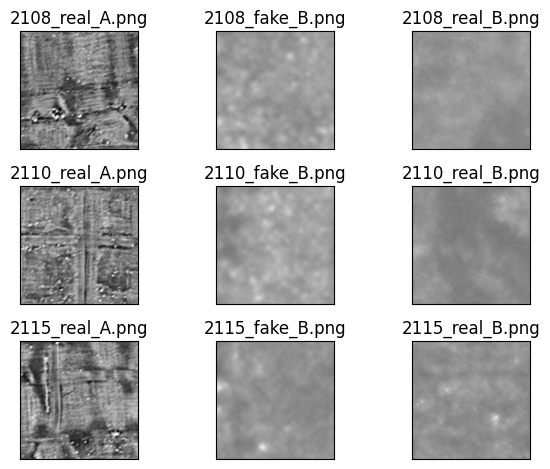

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3)

SAMPLES = [2108, 2110, 2115]

for j, s in enumerate(SAMPLES):    
    for i, fname in enumerate([f'{s}_real_A.png', f'{s}_fake_B.png', f'{s}_real_B.png']):
        img = plt.imread(f'./results/{MODEL_NAME}/test_latest/images/{fname}')
        ax = axs[j][i]
        ax.imshow(img)
        ax.set(yticks=[], yticklabels=[], xticks=[], xticklabels=[], title=fname)

fig.tight_layout()
plt.show()

# Export Test

In [41]:
from sp.data.img2label import Img2LabelDataset
from sp.data import ImagePrinter

EVAL_ROOT = Path('../data/output/denoiser_eval')
Img2LabelDataset.preprocess(
    REGION_SIZE,
    FRAGMENTS_DIR,
    outdir=EVAL_ROOT,
    sample_path=f'surface_volume/{SV}.tif',
    label_path='ir.png',
    mask_samples_only=False,
    splits=[
        ('test', ['3'])
    ])

Split: test:   0%|          | 0/1 [00:00<?, ?it/s]

Fold: 3:   0%|          | 0/630 [00:00<?, ?it/s]

Done!


## Fragment 3

  0%|          | 0/630 [00:00<?, ?it/s]

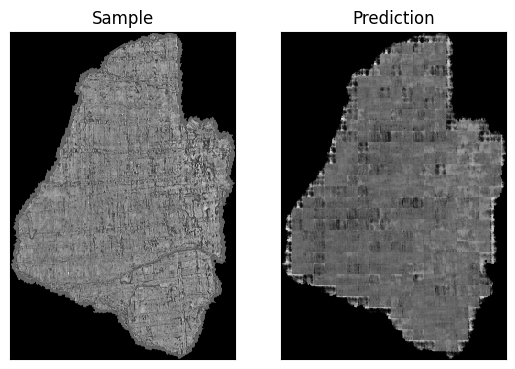

In [42]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sp.data import ImagePrinter, padding
from sp.data.img2label import Img2LabelDataset
from sp.inference import InkDetector
from IPython.display import Markdown
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from pathlib import Path

DENOISER_MODEL = Path('../build/denoiser_1685590830/denoiser_model.onnx')

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    _, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, (title, img) in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=title)
pred_image_paths = {}

ds = Img2LabelDataset(EVAL_ROOT, split='test')
PREDICTIONS_BASE_DIR = EVAL_ROOT
model = InkDetector(denoiser=DENOISER_MODEL)

for fragment_id, fragment_dir in [('3', FRAGMENTS_DIR / '3')]:
    display(Markdown(f'## Fragment {fragment_id}'))
    sample_img = Image.open(fragment_dir / f'surface_volume/{SV}.tif')
    
    pred_out_dir = PREDICTIONS_BASE_DIR
    pred_out_dir.mkdir(parents=True, exist_ok=True)
    pred_img = pred_out_dir / 'pred.png'
    pred_image_paths[fragment_id] = pred_img
    # NOTE: A bit hacky using the mask to compute size.
    with Image.open(fragment_dir / 'mask.png') as mask:
        size = mask.size
    with ImagePrinter(pred_img, size=size, channels=3) as pred_writer:
        for samples, _, regions, masks in tqdm(DataLoader(ds, batch_size=1, shuffle=False)):
            for sample, region, mask in zip(torch.unbind(samples), torch.unbind(regions), torch.unbind(masks)):
                with torch.no_grad():
                    pred = model(sample)
                region = tuple(region.numpy())
                pred = padding.unpad(
                    pred.squeeze(),
                    region,
                    REGION_SIZE)
                pred = (pred * mask.numpy() * 255).astype(np.uint8)
                pred_writer.write(region, pred)

    pred_final = Image.open(pred_img)
    grid = [
        ('Sample', sample_img),
        ('Prediction', pred_final),
    ]
    show(grid)